[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239934-lesson-1-parallelization)

# Parallel node execution

## Review

In module 3, we went in-depth on `human-in-the loop`, showing 3 common use-cases:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

## Goals

This module will build on `human-in-the-loop` as well as the `memory` concepts discussed in module 2.

We will dive into `multi-agent` workflows, and build up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent research assistant, we'll first discuss a few LangGraph controllability topics.

We'll start with [parallelization](https://langchain-ai.github.io/langgraph/how-tos/branching/#how-to-create-branches-for-parallel-node-execution).

## Fan out and fan in

Let's build a simple linear graph that over-writes the state at each step.

In [ ]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_mistralai langchain_community langgraph_sdk

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")

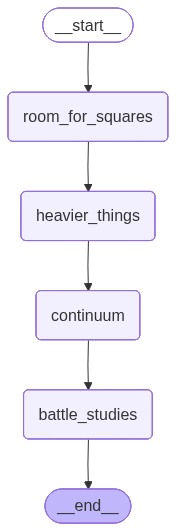

In [2]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes - Using John Mayer album names
builder = StateGraph(State)

# Initialize each node with John Mayer album titles
builder.add_node("room_for_squares", ReturnNodeValue("Room for Squares"))
builder.add_node("heavier_things", ReturnNodeValue("Heavier Things"))
builder.add_node("continuum", ReturnNodeValue("Continuum"))
builder.add_node("battle_studies", ReturnNodeValue("Battle Studies"))

# Flow
builder.add_edge(START, "room_for_squares")
builder.add_edge("room_for_squares", "heavier_things")
builder.add_edge("heavier_things", "continuum")
builder.add_edge("continuum", "battle_studies")
builder.add_edge("battle_studies", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

We over-write state, as expected.

In [3]:
graph.invoke({"state": []})

Adding Room for Squares to []
Adding Heavier Things to ['Room for Squares']
Adding Continuum to ['Heavier Things']
Adding Battle Studies to ['Continuum']


{'state': ['Battle Studies']}

Now, let's run `b` and `c` in parallel. 

And then run `d`.

We can do this easily with fan-out from `a` to `b` and `c`, and then fan-in to `d`.

The the state updates are applied at the end of each step.

Let's run it.

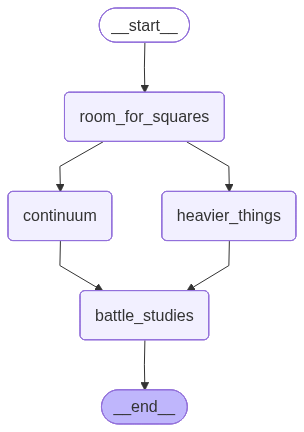

In [4]:
builder = StateGraph(State)

# Initialize each node with John Mayer albums
builder.add_node("room_for_squares", ReturnNodeValue("Room for Squares"))
builder.add_node("heavier_things", ReturnNodeValue("Heavier Things"))
builder.add_node("continuum", ReturnNodeValue("Continuum"))
builder.add_node("battle_studies", ReturnNodeValue("Battle Studies"))

# Flow - Fan out from first album to two parallel albums
builder.add_edge(START, "room_for_squares")
builder.add_edge("room_for_squares", "heavier_things")
builder.add_edge("room_for_squares", "continuum")
builder.add_edge("heavier_things", "battle_studies")
builder.add_edge("continuum", "battle_studies")
builder.add_edge("battle_studies", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

**We see an error**! 

This is because both `b` and `c` are writing to the same state key / channel in the same step. 

In [5]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding Room for Squares to []
Adding Continuum to ['Room for Squares']
Adding Heavier Things to ['Room for Squares']
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


When using fan out, we need to be sure that we are using a reducer if steps are writing to the same the channel / key. 

As we touched on in Module 2, `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

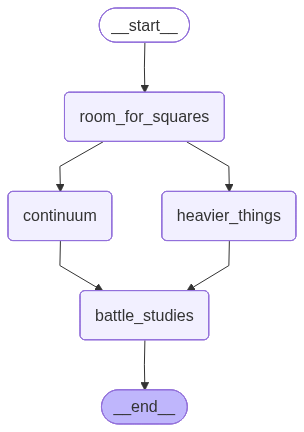

In [6]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with John Mayer albums
builder.add_node("room_for_squares", ReturnNodeValue("Room for Squares"))
builder.add_node("heavier_things", ReturnNodeValue("Heavier Things"))
builder.add_node("continuum", ReturnNodeValue("Continuum"))
builder.add_node("battle_studies", ReturnNodeValue("Battle Studies"))

# Flow
builder.add_edge(START, "room_for_squares")
builder.add_edge("room_for_squares", "heavier_things")
builder.add_edge("room_for_squares", "continuum")
builder.add_edge("heavier_things", "battle_studies")
builder.add_edge("continuum", "battle_studies")
builder.add_edge("battle_studies", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"state": []})

Adding Room for Squares to []
Adding Continuum to ['Room for Squares']
Adding Heavier Things to ['Room for Squares']
Adding Battle Studies to ['Room for Squares', 'Continuum', 'Heavier Things']


{'state': ['Room for Squares',
  'Continuum',
  'Heavier Things',
  'Battle Studies']}

Now we see that we append to state for the updates made in parallel by `b` and `c`.

## Waiting for nodes to finish

Now, lets consider a case where one parallel path has more steps than the other one.

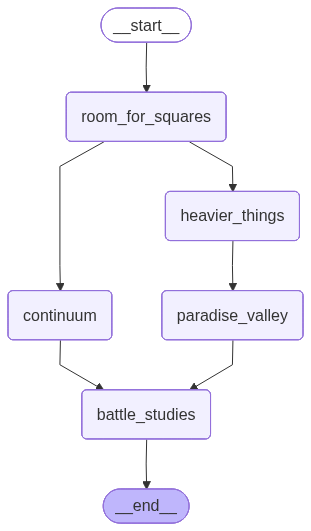

In [8]:
builder = StateGraph(State)

# Initialize each node with John Mayer albums
builder.add_node("room_for_squares", ReturnNodeValue("Room for Squares"))
builder.add_node("heavier_things", ReturnNodeValue("Heavier Things"))
builder.add_node("paradise_valley", ReturnNodeValue("Paradise Valley"))
builder.add_node("continuum", ReturnNodeValue("Continuum"))
builder.add_node("battle_studies", ReturnNodeValue("Battle Studies"))

# Flow
builder.add_edge(START, "room_for_squares")
builder.add_edge("room_for_squares", "heavier_things")
builder.add_edge("room_for_squares", "continuum")
builder.add_edge("heavier_things", "paradise_valley")
builder.add_edge(["paradise_valley", "continuum"], "battle_studies")
builder.add_edge("battle_studies", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In this case, `b`, `b2`, and `c` are all part of the same step.

The graph will wait for all of these to be completed before proceeding to step `d`. 

In [9]:
graph.invoke({"state": []})

Adding Room for Squares to []
Adding Continuum to ['Room for Squares']
Adding Heavier Things to ['Room for Squares']
Adding Paradise Valley to ['Room for Squares', 'Continuum', 'Heavier Things']
Adding Battle Studies to ['Room for Squares', 'Continuum', 'Heavier Things', 'Paradise Valley']


{'state': ['Room for Squares',
  'Continuum',
  'Heavier Things',
  'Paradise Valley',
  'Battle Studies']}

## Setting the order of state updates

However, within each step we don't have specific control over the order of the state updates!

In simple terms, it is a deterministic order determined by LangGraph based upon graph topology that **we do not control**. 

Above, we see that `c` is added before `b2`.

However, we can use a custom reducer to customize this e.g., sort state updates.

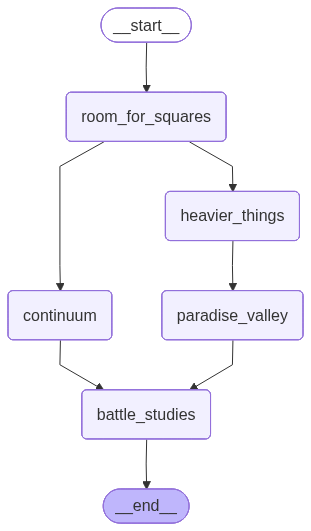

In [10]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]

# Add nodes
builder = StateGraph(State)

# Initialize each node with John Mayer albums
builder.add_node("room_for_squares", ReturnNodeValue("Room for Squares"))
builder.add_node("heavier_things", ReturnNodeValue("Heavier Things"))
builder.add_node("paradise_valley", ReturnNodeValue("Paradise Valley"))
builder.add_node("continuum", ReturnNodeValue("Continuum"))
builder.add_node("battle_studies", ReturnNodeValue("Battle Studies"))

# Flow
builder.add_edge(START, "room_for_squares")
builder.add_edge("room_for_squares", "heavier_things")
builder.add_edge("room_for_squares", "continuum")
builder.add_edge("heavier_things", "paradise_valley")
builder.add_edge(["paradise_valley", "continuum"], "battle_studies")
builder.add_edge("battle_studies", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({"state": []})

Adding Room for Squares to []
Adding Continuum to ['Room for Squares']
Adding Heavier Things to ['Room for Squares']
Adding Paradise Valley to ['Continuum', 'Heavier Things', 'Room for Squares']
Adding Battle Studies to ['Continuum', 'Heavier Things', 'Paradise Valley', 'Room for Squares']


{'state': ['Battle Studies',
  'Continuum',
  'Heavier Things',
  'Paradise Valley',
  'Room for Squares']}

Now, the reducer sorts the updated state values!

The `sorting_reducer` example sorts all values globally. We can also: 

1. Write outputs to a separate field in the state during the parallel step
2. Use a "sink" node after the parallel step to combine and order those outputs
3. Clear the temporary field after combining

See the [docs](https://langchain-ai.github.io/langgraph/how-tos/branching/#stable-sorting) for more details.


## Working with LLMs

Now, lets add a realistic example! 

We want to gather context from two external sources (Wikipedia and Web-Search) and have an LLM answer questions about John Mayer.

In [12]:
from langchain_mistralai import ChatMistralAI
llm = ChatMistralAI(model="mistral-large-latest", temperature=0)

In [13]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

You can try different web search tools. [Tavily](https://tavily.com/) is one nice option to consider, but ensure your `TAVILY_API_KEY` is set.

In [18]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")


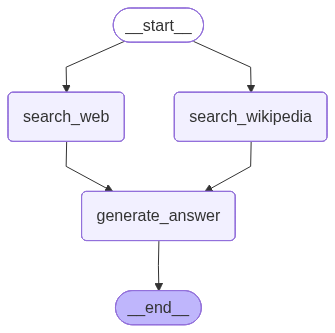

In [19]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
result = graph.invoke({"question": "How many Grammy Awards has John Mayer won and for which songs or albums?"})
result['answer'].content

/tmp/ipykernel_14240/3921850799.py:11: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


'John Mayer has won **seven Grammy Awards** for the following songs and albums:\n\n1. **Best Male Pop Vocal Performance** – *"Your Body Is a Wonderland"* (2002)\n2. **Song of the Year** – *"Daughters"* (2004)\n3. **Best Pop Song with Vocal** – *"Waiting on the World to Change"* (2006)\n4. **Best Pop Album** – *Continuum* (2006)'

## Using with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

In [21]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [22]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [23]:
thread = await client.threads.create()
input_question = {"question": "What are John Mayer's signature guitar playing techniques and influences?"}
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="parallelization", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])

John Mayer’s guitar playing is defined by a blend of **blues-rooted techniques**, **expressive phrasing**, and **innovative acoustic styles**, shaped by his deep influences from legendary guitarists. Here are his **signature techniques and key influences**:

---

### **Signature Techniques**
1. **Blues-Based Phrasing & Bends**
   - Mayer’s solos are steeped in **blues traditions**, featuring **sustained bends, vibrato, and graceful note choices** (e.g., the intro to *"Gravity"*).
   - He often pairs **bends with vibrato** (inspired by B.B. King) for emotional depth, as heard in *"Ain’t No Sunshine"* (live solo).
   - **Double stops** (playing two notes simultaneously, à la Jimi Hendrix) appear in songs like *"City Love"* and *"Slow Dancing in a Burning Room"*.

2. **Hybrid Picking & Fingerstyle**
   - Combines **pick and fingers** (hybrid picking) for fluidity, especially in blues licks (e.g., *"Vultures"*).
   - **Fingerstyle acoustic playing** with intricate **percussive slaps** (e.g